# Annotate Homographies
Large scale homography annotation for extraction of next best views.

In [1]:
import os
import cv2
import copy
import numpy as np
import torch
import torchvision
import torchvision.io as io
from torchvision.datasets.video_utils import VideoClips
from torch.utils.data import DataLoader
import sys

sys.path.append('../')

from utils import load_yaml, save_yaml, dictListToCompose, recursiveMethodCallFromDictList

servers = load_yaml('../configs/servers.yml')
server = servers['local']

databases = load_yaml('../configs/cholec80_transforms.yml')
database = databases['databases'][0]

In [6]:
# load transforms and convert them to torch.functional methods
key_dict = {
    'Crop': 'crop',
    'Resize': 'resize'
}

functional_databases = copy.deepcopy(databases)
for db_idx, db in enumerate(databases['databases']):
    functional_databases['databases'][db_idx]['transforms'] = [] # delete old transforms
    for transforms in db['transforms']:
        functional_transforms = []
        for transform in transforms:
            # 'Crop' -> 'crop', shape -> height, width, top_left_corner -> top, left
            # 'Resize' -> 'resize', dsize -> size
            functional_transform = {}
            for key, value in transform.items():
                if key == 'Crop':
                    functional_transform[key_dict[key]] = {
                        'height': value['shape'][0],
                        'width': value['shape'][1],
                        'top': value['top_left_corner'][0],
                        'left': value['top_left_corner'][1]
                    }
                elif key == 'Resize':
                    functional_transform[key_dict[key]] = {
                        'size': value['dsize'][::-1]
                    }
                else:
                    raise ValueError('Key not known')

            functional_transforms.append(functional_transform)                
        functional_databases['databases'][db_idx]['transforms'].append(functional_transforms)

save_yaml('../configs/cholec80_transforms_functional.yml', functional_databases)

In [2]:
import kornia
import cv2
from kornia import warp_perspective

from utils.processing import imageEdges, fourPtToMatrixHomographyRepresentation
from lightning_modules import DeepImageHomographyEstimationModuleBackbone

# load the model
# load best model\n",
model_prefix = '/home/martin/Tresors/homography_imitation_learning_logs/deep_image_homography_estimation_backbone/version_2'
# prefix = '/home/martin/Tresors/homography_imitation_learning_logs/unsupervised_deep_homography_estimation_backbone/version_0'
configs = load_yaml(os.path.join(model_prefix, 'configs.yml'))
model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(model_prefix, 'checkpoints/epoch=49.ckpt'), shape=configs['model']['shape'])

device = 'cpu'
if torch.cuda.is_available():
    print('Running with CUDA backend.')
    device = 'cuda'

model.to(device)
model = model.eval()

def forward_model(frame_i, frame_ip1):
    duv = model(frame_i, frame_ip1)

    uv = imageEdges(frame_i)
    H = fourPtToMatrixHomographyRepresentation(uv, duv)

    wrp = warp_perspective(frame_i, torch.inverse(H), frame_i.shape[-2:])

    return wrp, H, duv

Running with CUDA backend.


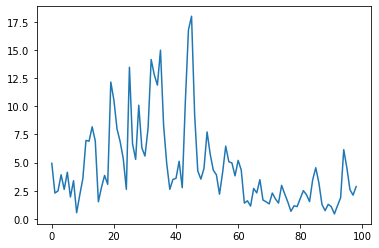

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
from utils.viz import yt_alpha_blend
import time

from datasets import VideoDataset

# load the transforms and videos from database
functional_databases = load_yaml('../configs/cholec80_transforms_functional.yml')
functional_database = functional_databases['databases'][0]

paths = [
    os.path.join(
        server['database']['location'], 
        functional_database['prefix'], 
        functional_database['videos']['prefix'], 
        x
    ) for x in functional_database['videos']['files'][:1]
]

paths = ['/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video01_short.mp4']

# video reader not compiled yet https://github.com/pytorch/vision/issues/1446
# video reading https://github.com/pytorch/vision/blob/ed5b2dc3a5e7411d8b40cc7e526e151983e99cf9/torchvision/datasets/video_utils.py#L45-L69
# dataset example check https://github.com/pytorch/vision/blob/ed5b2dc3a5e7411d8b40cc7e526e151983e99cf9/torchvision/datasets/kinetics.py#L50-L78

N = 100 # already 4 second preview horizon via N = 100 @ full res, image downscale 2x2 -> factor 4, easily 16 seconds preview horizon with 8GB memory
step = 1

vds = VideoDataset(paths, N+1, N, [functional_database['transforms'][0]])
vc = VideoClips(paths, clip_length_in_frames=N+1, frames_between_clips=N)


df = pd.DataFrame(columns=['t', 'duv', 'H']) # track results
global_idx = 0
max_clips = 150 # vc.num_clips()
max_clips = int(min(max_clips, len(vds)))

# live plot of homography norm
dH_list = []

def live_plot(x, y):
    clear_output(wait=True)
    plt.figure()
    plt.plot(x, y)
    plt.show()

with torch.no_grad():
    for i in range(max_clips):
        now = time.time_ns()
        # video, audio, info, video_idx = vc.get_clip(i)
        video = vds.__getitem__(i)
        print('\nLoading time: {} ms'.format((time.time_ns() - now)/1.e6))  # measure loading time

        # video = video.permute(0, 3, 1, 2)
        # transforms = functional_database['transforms'][video_idx]
        # video = recursiveMethodCallFromDictList(video, transforms, torchvision.transforms.functional)
        video = video.float()/255.

        # re-sort images into i and i+step
        frames_i, frames_ip1 = VideoDataset.framePairs(video, step)

        frames_i, frames_ip1 = frames_i.to(device), frames_ip1.to(device)

        now = time.time_ns()
        wrps, Hs, duvs = forward_model(frames_i, frames_ip1)
        print('Forwarding time: {} ms'.format((time.time_ns() - now)/1.e6))  # measure network forwarding time

        for idx, H in enumerate(Hs):
            df = df.append({
                't': global_idx,
                'duv': duvs[idx].squeeze().cpu().numpy(),
                'H': H.squeeze().cpu().numpy()
            }, ignore_index=True)
            global_idx += step
            print('\r{}/{}'.format(global_idx, max_clips*N), end='')

        frames_i = kornia.tensor_to_image(frames_i)
        frames_ip1 = kornia.tensor_to_image(frames_ip1)
        wrps = kornia.tensor_to_image(wrps)

        for idx, w in enumerate(wrps):
            # create moving plot of homography norm
            dH_norm = np.linalg.norm(Hs[idx].cpu().numpy()-np.eye(3))
            dH_list.append(dH_norm)
            if len(dH_list) == N:
                dH_list.pop(0)
            live_plot(np.arange(len(dH_list)), dH_list)

            # plot blends with and without warp
            blend0 = yt_alpha_blend(frames_ip1[idx], w)
            blend1 = yt_alpha_blend(frames_ip1[idx], frames_i[idx])
            blend0 = cv2.resize(blend0, (int(blend0.shape[1]/2), int(blend0.shape[0]/2)))
            blend1 = cv2.resize(blend1, (int(blend1.shape[1]/2), int(blend1.shape[0]/2)))
            composite = np.concatenate([blend0, blend1], axis=1)
            cv2.imshow('composite', composite)
            cv2.waitKey()
cv2.destroyAllWindows()

df.to_pickle('H_{}.pkl'.format(step))


In [15]:
# test import speed
import time
import importlib

now = time.time_ns()
for i in range(100000):
    module = importlib.import_module('torch')
    module.ones(1,1)
    continue
print((time.time_ns() - now)/1e6)

import torch

now = time.time_ns()
for i in range(100000):
    torch.ones(1,1)
    continue
print((time.time_ns() - now)/1e6)

1124.529334
221.526369
